In [25]:
import h5py
import pickle
import os
import gc
import json

import numpy as np
import math
import torch 
import torch.nn as nn
from functools import partial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")
import time
from torchsummary import summary
from tqdm import tqdm
from datetime import datetime

from lib.dls import gfem_2d, gfem_recon, gfem_recon_long  # Explicitly import required functions
from lib.dls_funcs import gfem_2d, gfem_recon  # Explicitly import required functions
from lib.eval import * # Imports analysis functions
from lib.transformer import TransformerEncoderModel, make_Sequence, train_model, normalize_data, denormalize_data, predict

Using device: cuda


In [2]:
# Load the combined configuration file
config_path = "configs/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
    # Print the keys and nested keys in the config file
    for key, value in config.items():
        if isinstance(value, dict):
            print(f"{key}")
            for sub_key, sub_value in value.items():
                print(f"  {sub_key}: {sub_value}")
                # load the sub_key as a variable
                globals()[sub_key] = sub_value


# Access parameters from the JSON file
data_name = config["data"]["data_name"]
patch_size = config["data"]["patch_size"]
num_modes = config["data"]["num_modes"]
num_train = config["train"]["num_train"]
num_test = config["train"]["num_test"]
time_lag = config["transformer"]["time_lag"]
d_model = config["transformer"]["d_model"]
nhead = config["transformer"]["nhead"]
num_layers = config["transformer"]["num_layers"]
ram_available = config["misc"]["ram_available"]


data
  data_name: ldc_30k_6ktrain
  patch_size: 19
  num_modes: 5
transformer
  time_lag: 64
  d_model: 512
  nhead: 4
  num_layers: 4
train
  lr: 0.001
  num_epochs: 1000
  patience: 25
  train_ahead: 5
  num_train: 6000
  num_test: 600
  test_split: 0.1
  val_split: 0.2
  batch_size: 256
misc
  overwrite_latent: False
  overwrite_latent_eval: False
  overwrite_true_stats: False
  seed: 42
  animate_flag: False
  visualize_flow_flag: False
  ram_available: 100


In [3]:
# Make directories for saving figures and animations
fig_dir = 'figs/' + data_name + '/'
latent_id = 'm' + str(num_modes) + 'p' + str(patch_size) + '/'
anim_dir = 'anim/' + data_name + '/'

os.makedirs('figs', exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(fig_dir + latent_id, exist_ok=True)
os.makedirs('anim', exist_ok=True)
os.makedirs(anim_dir, exist_ok=True)
os.makedirs(anim_dir + latent_id, exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Define paths for saving model and predictions
model_dir = f'models/{data_name}/{latent_id}'
predictions_dir = f'predictions/{data_name}/{latent_id}'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)

model_save_path = os.path.join(model_dir, 'model.pth')
normalization_params_save_path = os.path.join(model_dir, 'normalization_params.npz')

latent_name = 'dls_' + data_name + '_m' + str(num_modes) + '_p' + str(patch_size)
latent_file = 'latent/' + latent_name + '.h5'
latent_config_file = 'latent/' + latent_name + '_config.pkl'
latent_metrics = 'latent/' + latent_name + '_metrics.txt'

data_dir = 'data/'
data_path = data_dir + data_name + '.h5'
with h5py.File(data_path, 'r') as f:
    print(f['UV'].shape)

(12000, 512, 512, 2)


In [4]:
with open(latent_config_file, 'rb') as f:
        config = pickle.load(f)

In [5]:
# load predictions
num_predictions = 2 * num_train - time_lag 
pred_path = os.path.join(predictions_dir, f'predictions_num{num_predictions}.h5')
with h5py.File(pred_path, 'r') as f:
    print(f['predictions'].shape)
    pred = f['predictions'][:]

pred_u = pred[:, :config.num_gfem_nodes*config.dof_node]
pred_v = pred[:, config.num_gfem_nodes*config.dof_node:]
del pred

(12000, 38988)


In [6]:
# reconstruct the predictions
rec_path = os.path.join(predictions_dir, f'rec_num{num_predictions}.h5')
if os.path.exists(rec_path):
    print(f"Reconstruction file {rec_path} already exists. Loading it.")
else:
    gfem_recon_long(rec_path, config, dof_u = pred_u.T, dof_v=pred_v.T, batch_size=pred_u.shape[0] // 10)

with h5py.File(rec_path, 'r') as f:
    print(f['Q_rec'].shape)

Reconstruction file predictions/ldc_30k_6ktrain/m5p19/rec_num11936.h5 already exists. Loading it.
(2, 505, 505, 12000)


In [ ]:
with h5py.File(rec_path, 'r+') as f:
    if 'tke_pred' not in f.keys():
        tke_pred = 1/2 * np.sum(f['Q_rec'][:]**2, axis=(0, 1, 2))
        f.create_dataset('tke_pred', data=tke_pred)
        print("tke_pred saved to rec_path.")
    else:
        tke_pred = f['tke_pred'][:]
        print("tke_pred loaded from rec_path.")

In [12]:
with h5py.File(rec_path, 'r+') as g:
    if 'tke_truth' not in g.keys():
        with h5py.File(data_path, 'r') as f:
            mean_uv = f['mean'][:config.nx_t,:config.ny_t,:]
            tke_truth = 1/2* np.sum((f['UV'][:num_predictions + time_lag,:config.nx_t,:config.ny_t,:] - mean_uv[np.newaxis,...] )**2, axis=(1,2,3))
        g.create_dataset('tke_truth', data=tke_truth)
        print("tke_truth saved to rec_path.")
    else:
        tke_truth = g['tke_truth'][:]
        print("tke_truth loaded from rec_path.")
    print(f"tke_truth shape: {tke_truth.shape}")

tke_truth loaded from rec_path.
tke_truth shape: (12000,)


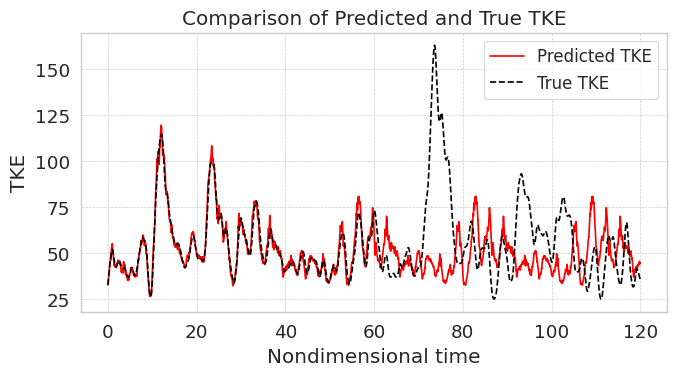

TKE error: 36.785%


In [37]:
plt.figure(figsize=(7, 4))
t = np.arange(tke_pred.shape[0]) / 100
plt.plot(t, tke_pred, label='Predicted TKE', color='r', linestyle='-')
plt.plot(t, tke_truth, label='True TKE', color='k', linestyle='--')

plt.xlabel('Nondimensional time')
plt.ylabel('TKE')
plt.title('Comparison of Predicted and True TKE')
plt.legend(loc='upper right', fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(fig_dir + latent_id + 'tke_comparison.pdf', dpi=300)
plt.savefig(fig_dir + latent_id + 'tke_comparison.png', dpi=300)
plt.show()

# Calculate the error
tke_error = np.linalg.norm(tke_pred - tke_truth) / np.linalg.norm(tke_truth)
print(f"TKE error: {100*tke_error:.3f}%")

In [ ]:
# save point probe data for frequency analysis
x = np.linspace(0, 1, config.nx)
y = np.linspace(0, 1, config.ny)
x = x[:config.nx_t]
y = y[:config.ny_t]
X, Y = np.meshgrid(x, y)

# find y closest  = 0.112
y_closest = np.argmin(np.abs(y - 0.112))
# print('y_closest: ', y[y_closest])

# find x closest to 0.233 and 0.765
x_closest1 = np.argmin(np.abs(x - 0.233))
x_closest2 = np.argmin(np.abs(x - 0.765))
# print('x_closest1: ', x[x_closest1])
# print('x_closest2: ', x[x_closest2])

point_1 = (x[x_closest1], y[y_closest])
point_2 = (x[x_closest2], y[y_closest])
point_1_idx = (x_closest1, y_closest)
point_2_idx = (x_closest2, y_closest)

y_closest:  0.11154598825831702
x_closest1:  0.2328767123287671
x_closest2:  0.7651663405088063


In [44]:
# pull point probe data from the truth data and reconstructed predictions
with h5py.File(data_path, 'r') as f:
    mean_uv_p1 = f['mean'][point_1_idx[0], point_1_idx[1], :]
    mean_uv_p2 = f['mean'][point_2_idx[0], point_2_idx[1], :]
    uv_p1 = f['UV'][:num_predictions + time_lag, point_1_idx[0], point_1_idx[1], :] - mean_uv_p1[np.newaxis, ...]
    uv_p2 = f['UV'][:num_predictions + time_lag, point_2_idx[0], point_2_idx[1], :] - mean_uv_p2[np.newaxis, ...]

with h5py.File(rec_path, 'r') as f:
    uv_rec_p1 = f['Q_rec'][:num_predictions + time_lag, point_1_idx[0], point_1_idx[1], :].T
    uv_rec_p2 = f['Q_rec'][:num_predictions + time_lag, point_2_idx[0], point_2_idx[1], :].T

In [45]:
data_dict = {
    "ground_truth": {
        "point_1": uv_p1,
        "point_2": uv_p2
    },
    "prediction": {
        "point_1": uv_rec_p1,
        "point_2": uv_rec_p2
    }
}
# window 1 for comparison is :6000, window 2 is 6000:
windows = {
    "window_1": slice(0, 6000),
    "window_2": slice(6000, 12000) 
}

In [50]:
from scipy.signal import welch, correlate, coherence, correlation_lags
def psd(data, fs = 100, nperseg = 256):
    """
    Calculate the Power Spectral Density (PSD)
    """
    f, Pxx_u = welch(data, fs)
    return f, Pxx_u
def cpsd(data1, data2, fs = 100, nperseg = 256):
    """
    Calculate the Cross Power Spectral Density (CPSD)
    """
    f, Cxy = coherence(data1, data2, fs)
    return f, Cxy
def corr(data1, data2):
    """
    Calculate the auto or cross-correlation
    """
    corr = correlate(data1, data2, mode='full')
    lags = correlation_lags(len(data1), len(data2), mode='full')
    return lags, corr


psd_results = {}

# Loop through data types (ground truth and prediction), points, and windows
for data_type, points in data_dict.items():
    psd_results[data_type] = {}
    for point_name, data in points.items():
        psd_results[data_type][point_name] = {}
        for window_name, window_slice in windows.items():
            # Compute PSD for the u-component
            f_u, Pxx_u = psd(data[window_slice, 0])
            f_v, Pxx_v = psd(data[window_slice, 1])
            # Combine u and v components into a single array
            Pxx = np.array([Pxx_u, Pxx_v])
            psd_results[data_type][point_name][window_name] = Pxx

psd_results['f'] = f_u

Text(0.5, 0, 'Frequency (Hz)')

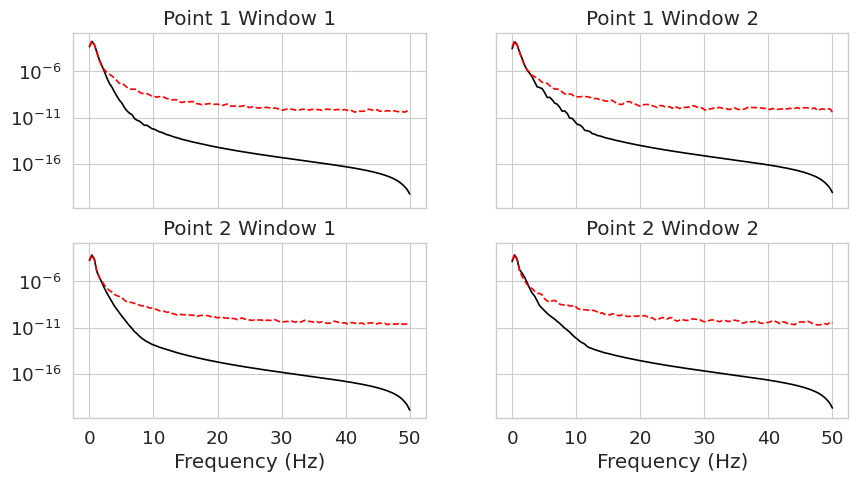

In [68]:
# plot the PSD results
fig, axs = plt.subplots(2, 2, figsize=(10, 5),sharex=True, sharey=True)
axs[0,0].semilogy(psd_results['f'], psd_results['ground_truth']['point_1']['window_1'][0], label='Ground Truth Point 1 Window 1', color='k', linestyle='-')
axs[0,0].semilogy(psd_results['f'], psd_results['prediction']['point_1']['window_1'][0], label='Prediction Point 1 Window 1', color='r', linestyle='--')
axs[0,1].semilogy(psd_results['f'], psd_results['ground_truth']['point_1']['window_2'][0], label='Ground Truth Point 1 Window 2', color='k', linestyle='-')
axs[0,1].semilogy(psd_results['f'], psd_results['prediction']['point_1']['window_2'][0], label='Prediction Point 1 Window 2', color='r', linestyle='--')
axs[1,0].semilogy(psd_results['f'], psd_results['ground_truth']['point_2']['window_1'][0], label='Ground Truth Point 2 Window 1', color='k', linestyle='-')
axs[1,0].semilogy(psd_results['f'], psd_results['prediction']['point_2']['window_1'][0], label='Prediction Point 2 Window 1', color='r', linestyle='--')
axs[1,1].semilogy(psd_results['f'], psd_results['ground_truth']['point_2']['window_2'][0], label='Ground Truth Point 2 Window 2', color='k', linestyle='-')
axs[1,1].semilogy(psd_results['f'], psd_results['prediction']['point_2']['window_2'][0], label='Prediction Point 2 Window 2', color='r', linestyle='--')
axs[0,0].set_title('Point 1 Window 1')
axs[0,1].set_title('Point 1 Window 2')
axs[1,0].set_title('Point 2 Window 1')
axs[1,1].set_title('Point 2 Window 2')
axs[1,0].set_xlabel('Frequency (Hz)')
axs[1,1].set_xlabel('Frequency (Hz)')
